# Part 0: Import, Directory and Preference settings

In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random

In [2]:
# Set options

%matplotlib inline
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.options.display.max_columns=100
pd.options.display.max_rows=100

# Fix random seed
np.random.seed(42)
random.seed(42)

In [3]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

In [5]:
# Set data paths

data_path = os.path.join(data_dir, 'Data')

train_path = os.path.join(data_dir, 'train.csv')

holdout_path = os.path.join(data_dir, 'test.csv')

In [6]:
# Set model path

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'Model')

# set embedding directory
embedding_dir = 'Z:\\Jupyter\\Embeddings'

In [7]:
# Read the dataset

train = pd.read_csv(train_path)
holdout = pd.read_csv(holdout_path)

In [8]:
# Define cleaning modules and cleaning functions

import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from custom_function.contractions import CONTRACTION_MAP
from unicodedata import normalize

# Import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

# Create stopwords list        
STOPWORDS = set(stopwords.words('english'))

# Define lemmatizing functions
def lemmatize_doc(document):
    """ 
    Conduct pre-processing, tag words then returns sentence with lemmatized words
    """
    
    # Create an empty list of lemmatized tokens
    lemmatized_list = []
    
    # Tokenize the sentences
    tokenized_sent = sent_tokenize(document)
    
    # Iterate over sentences to conduct lemmatization
    for sentence in tokenized_sent:
        
        # Tokenize the words in the sentence
        tokenized_word = word_tokenize(sentence)
        
        # Tag the pos of the tokens
        tagged_token = pos_tag(tokenized_word)
        
        # Initialize a empty list of lemmatized words
        root = []

        # Create Lemmatizer object
        lemma = WordNetLemmatizer()

        # iterate over the tagged sentences to 
        for token in tagged_token:

            # assign tag and actual word of the token
            tag = token[1][0]
            word = token[0]

            # Lemmatize the token based on tags
            if tag.startswith('J'):
                root.append(lemma.lemmatize(word, wordnet.ADJ))
            elif tag.startswith('V'):
                root.append(lemma.lemmatize(word, wordnet.VERB))
            elif tag.startswith('N'):
                root.append(lemma.lemmatize(word, wordnet.NOUN))
            elif tag.startswith('R'):
                root.append(lemma.lemmatize(word, wordnet.ADV))
            else:          
                root.append(word)

        # Add the lemmatized word into our list
        lemmatized_list.extend(root)
        
    return " ".join(lemmatized_list)

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """
    Expand the contractions form to create cohenrent extractions
    """
    
    # Substitute quotation marks with apostrophes
    text = re.sub("’", "'", text)
    
    # define the contraction pattern with custom contraction mappings
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    
    # Define function to expand contraction matches
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Define main text cleaning function
def clean_text(text):
    """
    Return a processed version of the text given
    """
    # Turn all text into lower case
    text = text.lower()
    
    # Expand all contractions
    text = expand_contractions(text)
    
    # Remove all links
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    # Remove all punctuations, except hyphens
    text = re.sub(r"[%;$`“”\,.!?():\[\]\/]", ' ', text)

    # Remove all shortened words (like " d " from "you'd")
    #no_shorten = re.sub(r"\s[dtms]\s", ' ', no_punctuation)
    #no_shorten = re.sub(r"\sre\s", ' ', no_shorten)

    # Remove all numerics stands by itself
    text = re.sub(r"(?<=\s)\d+(?=\s)", ' ', text)

    # Lemmatize text
    text = lemmatize_doc(text)
    
    # Remove stand-alone hyphens
    text = re.sub(r"\s-\s", ' ', text)
    
    # Removing Extra spaces
    text = re.sub(r'[\s]+', ' ', text)
    
    # Convert 
    return text
    

[nltk_data] Downloading package wordnet to C:\Users\Zach
[nltk_data]     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zach
[nltk_data]     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Zach Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\Zach Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


In [9]:
%%time
# Apply the pre-processing algorithm into a new dataframe: train_processed

train_processed = train[['text', 'drug', 'sentiment']]
holdout_processed = holdout[['text', 'drug']]

train_processed.text = train_processed.text.apply(clean_text)
holdout_processed.text = holdout_processed.text.apply(clean_text)

Wall time: 3min 25s


In [10]:
train_processed = train_processed.sort_index()

In [11]:
train_processed.head()

,text,drug,sentiment
0,autoimmune disease tend come cluster gilenya –...,gilenya,2
1,completely understand would want try it but re...,gilenya,2
2,interest target s1p-1 receptor rather 1-5 like...,fingolimod,2
3,interesting grand merci wonder lemtrada ocrevu...,ocrevus,2
4,hi everybody late mri result brain cervical co...,gilenya,1


# Logistic Regression

In [12]:
# Import Naive Bayes

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from custom_function.ml import create_classifier, evaluate_classifier, get_model_results
import pickle

In [13]:
f1_grid = {}
for cut in np.arange(0,1, 0.1):
    train_copy = train_processed.copy(deep = True)
    remove_n = int(cut * len(train_copy))
    drop_indices = np.random.choice(train_copy.index, remove_n, replace=False)
    train_subset = train_copy.drop(drop_indices)
    print("Number of samples taken is %d" % len(train_subset))
    
    # Define X and y

    X = train_subset.text
    y = train_subset.sentiment
    indices = train_subset.index

    # Split train and test set

    Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)
    
    # Build model
    vec = TfidfVectorizer(min_df = 1, ngram_range = (1,2)).fit(Xtrain)
    Xtrain = vec.transform(Xtrain)
    Xtest = vec.transform(Xtest)
    clf = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', C = 0.01)
    clf.fit(Xtrain, ytrain)
    
    
    # Extract classifier score
    f1macro_score, cm = evaluate_classifier(clf,
                                           Xtest,
                                           ytest)

    # Print score
    print(f1macro_score)
    print(cm)
    
    # Save score
    f1_grid[len(train_subset)] = f1macro_score

Number of samples taken is 5279
0.4667103420451175
[[ 42  34  35]
 [ 17 108  50]
 [108 212 450]]
Number of samples taken is 4752
0.45005235888485356
[[ 32  45  50]
 [ 11  90  57]
 [ 81 166 419]]
Number of samples taken is 4224
0.44313109727891287
[[ 33  29  51]
 [  8  77  46]
 [ 74 177 350]]
Number of samples taken is 3696
0.4353594949925226
[[ 19  21  28]
 [  6  60  48]
 [ 55 156 347]]
Number of samples taken is 3168
0.4312688038290646
[[ 18  24  33]
 [  7  54  30]
 [ 49 135 284]]
Number of samples taken is 2640
0.44349868295323586
[[ 14  15  27]
 [ 11  50  32]
 [ 45  93 241]]
Number of samples taken is 2112
0.4673514099743608
[[ 13   7  12]
 [ 10  34  31]
 [ 36  67 213]]
Number of samples taken is 1584
0.4680256471262895
[[  6   2  17]
 [  4  22  35]
 [ 15  32 184]]
Number of samples taken is 1056
0.42781990845118534
[[  2   5  18]
 [  0  11  16]
 [  1  25 134]]
Number of samples taken is 528
0.37617135207496655
[[ 0  1 13]
 [ 0  5 11]
 [ 2  8 66]]


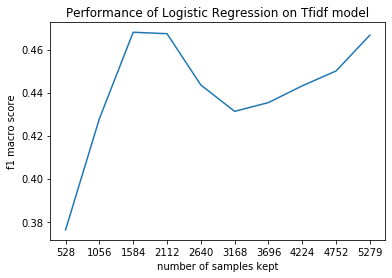

In [14]:
plt.plot(*zip(*sorted(f1_grid.items())))
plt.title("Performance of Logistic Regression on Tfidf model")
plt.xticks(list(f1_grid.keys()))
plt.xlabel("number of samples kept")
plt.ylabel("f1 macro score")
plt.show()

# Word2Vec Model

In [15]:
from gensim.models import Word2Vec, KeyedVectors

In [16]:
def get_mean_vector(word2vec_model, n_dim, doc):
    """ 
    From a document, derive the mean vector of its vocabularies with embeddings from a specified word2vec model with dimension n
    """
    
    # remove out-of-vocabulary words
    word_list = [word for word in doc if word in word2vec_model.wv.vocab]
    
    # Take average if the doc contains in-vocabulary words, else, take a matrix of zeroes
    if len(word_list) >= 1:
        return np.mean(word2vec_model[word_list], axis=0)
    else:
        return ([0] * n_dim)

In [17]:
f1_grid_w2v = {}
for cut in np.arange(0,1, 0.1):
    train_copy = train_processed.copy(deep = True)
    remove_n = int(cut * len(train_copy))
    drop_indices = np.random.choice(train_copy.index, remove_n, replace=False)
    train_subset = train_copy.drop(drop_indices)
    print("Number of samples taken is %d" % len(train_subset))
    
    # Define hyper-parameters
    n_window = 7
    n_dim = 200

    sentences = [row.split() for row in train_subset.text]
    
    w2v_model = Word2Vec(min_count=10,
                         window=n_window,
                         size=n_dim,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=1)

    w2v_model.build_vocab(sentences)

    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

    w2v_model.save(os.path.join(embedding_dir, 'w2v_best.bin'))

    #### Derive word2vec features

    # Create a dictionary with the vocabs and its embeddings
    w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

    # Initialize a vector features dictionary
    vec_features = {}

    # Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
    for index, doc in train_subset.text.iteritems(): 
        vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

    # Create a document feature dataframe
    vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
    vec_features_df.shape


    # Define X and y

    X = vec_features_df
    y = train_subset.sentiment
    indices = train_subset.index

    # Split train and test set

    Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)
    
    # Build model
    clf = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', C = 0.01)
    clf.fit(Xtrain, ytrain)
    
    
    # Extract classifier score
    f1macro_score, cm = evaluate_classifier(clf,
                                           Xtest,
                                           ytest)

    # Print score
    print(f1macro_score)
    print(cm)
    
    # Save score
    f1_grid_w2v[len(train_subset)] = f1macro_score

Number of samples taken is 5279
0.48460897943313563
[[ 61  28  22]
 [ 23 107  45]
 [138 207 425]]
Number of samples taken is 4752
0.4852435432515058
[[ 54  31  25]
 [ 18 106  34]
 [127 186 370]]
Number of samples taken is 4224
0.4468698952817607
[[ 36  37  36]
 [ 14  91  36]
 [121 152 322]]
Number of samples taken is 3696
0.444472540369183
[[ 37  29  30]
 [ 14  70  28]
 [ 84 168 280]]
Number of samples taken is 3168
0.4387719819263469
[[ 34  24  29]
 [ 12  59  21]
 [ 74 151 230]]
Number of samples taken is 2640
0.43346717137865953
[[ 19  19  24]
 [  5  46  29]
 [ 72  92 222]]
Number of samples taken is 2112
0.4330942904209189
[[ 24  18  14]
 [ 13  31  13]
 [ 63  81 166]]
Number of samples taken is 1584
0.4340088432463272
[[  9  14  13]
 [  6  37  13]
 [ 44  57 124]]
Number of samples taken is 1056
0.31903210100026463
[[ 6 15  8]
 [ 6 13  8]
 [35 54 67]]
Number of samples taken is 528
0.32940332759609864
[[ 1  8  1]
 [ 1 17  3]
 [12 37 26]]


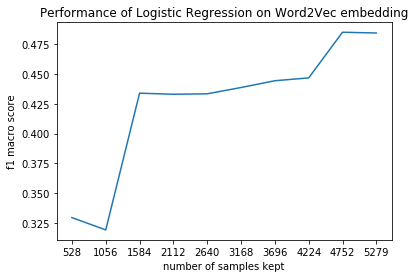

In [18]:
plt.plot(*zip(*sorted(f1_grid_w2v.items())))
plt.title("Performance of Logistic Regression on Word2Vec embedding")
plt.xticks(list(f1_grid.keys()))
plt.xlabel("number of samples kept")
plt.ylabel("f1 macro score")
plt.show()

In [22]:
def mergeDict(dict1, dict2):
    """
    Merge dictionaries and keep values of common keys in list
    """
    
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = [value, dict1[key]]
    return dict3

In [37]:
both_score = mergeDict(f1_grid, f1_grid_w2v)

In [38]:
both_score_df = pd.DataFrame.from_dict(both_score, orient = 'index')

In [39]:
both_score_df.columns = ["LR-W2V", "LR-TFIDF"]

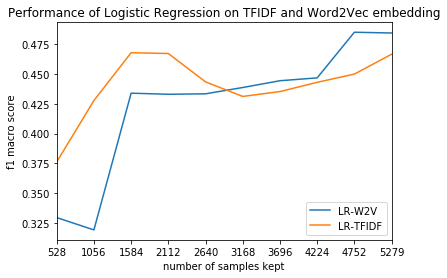

In [40]:
both_score_df.plot()
plt.title('Performance of Logistic Regression on TFIDF and Word2Vec embedding')
plt.xticks(list(both_score_df.index))
plt.xlabel("number of samples kept")
plt.ylabel("f1 macro score")
plt.show()